# Binary Prediction of Poisonous Mushrooms
**Playground Series - Season 4, Episode 8**

## [Dataset](https://www.kaggle.com/competitions/playground-series-s4e8/data) Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the UCI Mushroom dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

Note: Unlike many previous Tabular Playground datasets, data artifacts have not been cleaned up. There are categorical values in the dataset that are not found in the original. It is up to the competitors how to handle this.

**My Approach**:
I will check the data and I won't do full eda again if the data is similar to the original dataset. Instead, I will focus on the model building and hyperparameter tuning.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from IPython import get_ipython
import os

import suraj_datalab as sdl

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('../input/train.csv')
df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


**Opinion**:
Kaggle have put some numerical columns in the dataset which are not present in the original dataset. So new approach will required to handle these columns. Also it looks like they have put lots of null values in the dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [5]:
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

## Missing Values

In [6]:
df.shape

(3116945, 22)

In [7]:
def get_missing_values_summary(dataframe, filter=True):
    """
    Generates a summary of missing values in the dataframe.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe to analyze.

    Returns:
    pd.DataFrame: A dataframe containing the count and percentage of missing values, 
                  along with the data type of each column that has missing values.
    """
    missing_values_summary = pd.DataFrame({
        'Missing Count': dataframe.isnull().sum(),
        'Missing Percentage': (dataframe.isnull().sum() / len(dataframe) * 100).round(2),
        'Data Type': dataframe.dtypes
    })

    # Filter out columns with no missing values
    if filter:
        missing_values_summary = missing_values_summary[missing_values_summary['Missing Count'] > 0]

    return missing_values_summary


get_missing_values_summary(df, filter=False)

,Missing Count,Missing Percentage,Data Type
id,0,0.00,int64
class,0,0.00,object
cap-diameter,4,0.00,float64
cap-shape,40,0.00,object
cap-surface,671023,21.53,object
cap-color,12,0.00,object
does-bruise-or-bleed,8,0.00,object
gill-attachment,523936,16.81,object
gill-spacing,1258435,40.37,object
gill-color,57,0.00,object


I will drop the rows with high missing values in initial model building. Later we will try to do some feature engineering to fill the missing values. 
For the missing values less than 40% I will use the mode for categorical columns and median for numerical columns to fill the missing values.

In [ ]:
missing_values = get_missing_values_summary(df)
df = df.drop(columns= missing_values[missing_values['Missing Percentage'] > 40].index)

In [ ]:
get_missing_values_summary(df)

## Value Counts

In [9]:
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

In [10]:
df[cat_cols].nunique()

class                    2
cap-shape               74
cap-surface             83
cap-color               78
does-bruise-or-bleed    26
gill-attachment         78
gill-spacing            48
gill-color              63
stem-root               38
stem-surface            60
stem-color              59
veil-type               22
veil-color              24
has-ring                23
ring-type               40
spore-print-color       32
habitat                 52
season                   4
dtype: int64

So many unique values in many of the columns seems like unnatual data. Let's check it one by one. In origial dataset, the categorical columns have very less unique values.

In [ ]:
df['cap-shape'].value_counts().index

In [ ]:
df['cap-shape'].value_counts()

In [ ]:
# Calculate the percentage of each category in the 'cap-shape' column
category_percentages = df['cap-shape'].value_counts(normalize=True) * 100

# Identify categories with less than 2% occurrence
rare_categories = category_percentages[category_percentages < 2].index

# Replace the rare categories with 'Others'
df['cap-shape'] = np.where(df['cap-shape'].isin(rare_categories), 'Others', df['cap-shape'])

# Verify the changes
df['cap-shape'].value_counts(normalize=True) * 100

Most values in the `cap-shape` column align with few categorical labels. However, there are several unexpected values, including numbers and strings that appear to be noise introduced during the synthetic data generation process.
Let's group these values into a single category and check the value counts of the column.

In [11]:
def replace_rare_categories(df, column_name, proportion_threshold=0.02, replacement_value='Others'):
    """
    Replaces categories in a specified column that occur less frequently than the given proportion threshold.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to modify.
    proportion_threshold (float): The proportion threshold below which categories are considered rare. Default is 0.02.
    replacement_value (str): The value to replace rare categories with. Default is 'Others'.

    Returns:
    pd.DataFrame: The DataFrame with rare categories replaced.
    """
    # Calculate the percentage of each category
    category_percentages = df[column_name].value_counts(normalize=True)

    # Identify categories with less than the threshold occurrence
    rare_categories = category_percentages[category_percentages < proportion_threshold].index

    # Replace rare categories with the replacement value
    df[column_name] = np.where(df[column_name].isin(rare_categories), replacement_value, df[column_name])

    return df

In [12]:
for col in cat_cols:
    df = replace_rare_categories(df, col, proportion_threshold=0.01)

In [13]:
df[cat_cols].nunique()

class                    2
cap-shape                8
cap-surface             12
cap-color               13
does-bruise-or-bleed     3
gill-attachment          8
gill-spacing             4
gill-color              13
stem-root                5
stem-surface             8
stem-color              10
veil-type                2
veil-color               7
has-ring                 3
ring-type                8
spore-print-color        8
habitat                  6
season                   4
dtype: int64

With proportion_threshold=0.02, I was getting the number of unique values in `gill-color` column as 10. But in original data (UCI Mushroom dataset), the number of unique values in `gill-color` column is 12. So I changed the proportion_threshold to 0.01 and I got the number of unique values in `gill-color` column as 13. The 13th values is for the rare values, which is `Others`.

In [14]:
df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [15]:
def is_jupyter_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if 'ZMQInteractiveShell' in shell:
            return True  # Jupyter notebook or JupyterLab
        elif 'TerminalInteractiveShell' in shell:
            return False  # Terminal running IPython
        else:
            return False  # Other type (likely terminal)
    except NameError:
        return False  # Probably standard Python interpreter

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def categorical_feature(df, feature, target):
    """
    Analyzes the distribution of a categorical feature in relation to the target variable.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    feature (str): The name of the categorical feature to analyze.
    target (str): The target variable for analysis.

    Returns:
    pd.DataFrame: A dataframe summarizing the count and percentage distribution of the feature, 
                  along with counts for each class in the target variable.
    """
    # Calculate the distribution of the feature
    category_distribution = pd.DataFrame({
        'Total Count': df[feature].value_counts(),
        'Total Percentage': df[feature].value_counts(normalize=True) * 100,
    })

    # Add counts for each target class
    for class_value in df[target].unique():
        category_distribution[f'{class_value} of Total (%)'] = df[df[target] == class_value][feature].value_counts(normalize=True) * 100

    for class_value in df[target].unique():
        category_distribution[f'{class_value} within {feature} value (%)'] = df[df[target] == class_value][feature].value_counts() / df[feature].value_counts() * 100

    # Sort the categories by count
    order = df[feature].value_counts().index

    # Plot the distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=feature, hue=target, order=order)
    plt.title(f'Distribution of {feature} by {target}')
    if is_jupyter_notebook():
        plt.show()  # Show plot if in Jupyter notebook
    else:
        # Ensure the plot directroy exists
        if not os.path.exists('./plots'):
            os.makedirs('./plots')
        plt.savefig(f'./plots/{feature}-{target}-distribution.png')

    return category_distribution


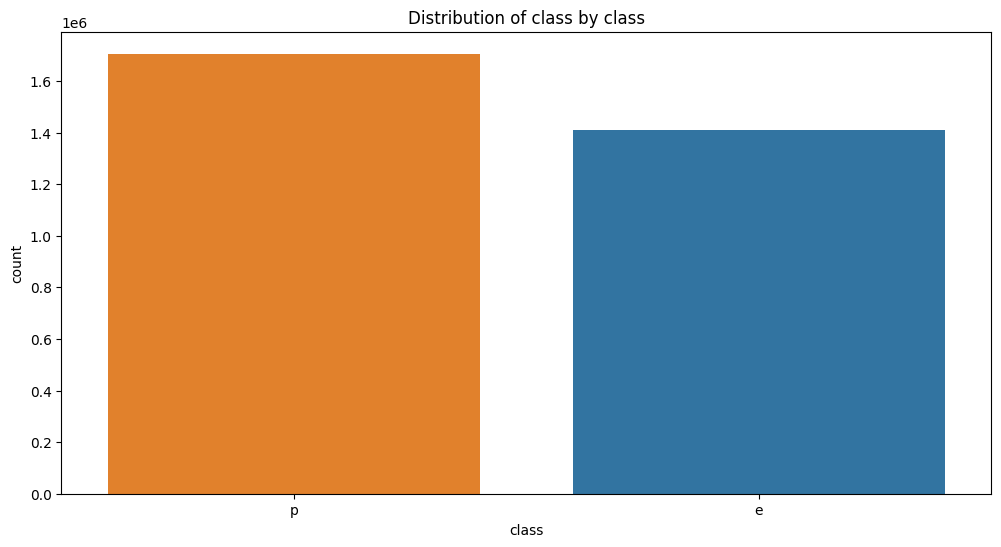

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within class value (%),p within class value (%)
class,,,,,,
p,1705396,54.713702,NaN,100.0,NaN,100.0
e,1411549,45.286298,100.0,NaN,100.0,NaN


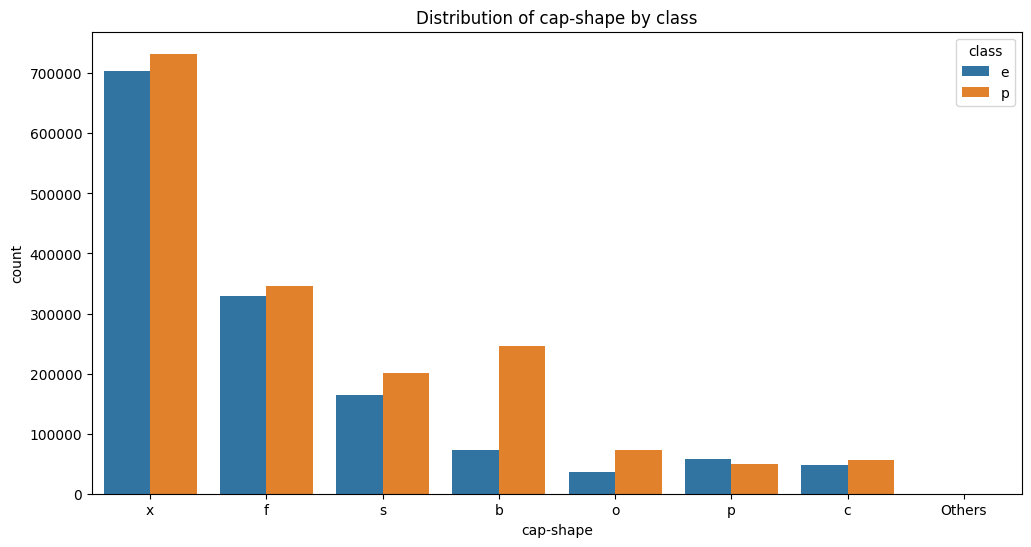

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within cap-shape value (%),p within cap-shape value (%)
cap-shape,,,,,,
x,1436026,46.072177,49.833231,42.959148,48.983375,51.016625
f,676238,21.695817,23.381763,20.300357,48.805598,51.194402
s,365146,11.715019,11.654963,11.764727,45.054307,54.945693
b,318646,10.223154,5.123568,14.444088,22.696346,77.303654
o,108835,3.491765,2.507340,4.306575,32.518951,67.481049
p,106967,3.431834,4.096672,2.881546,54.059663,45.940337
c,104520,3.353326,3.385603,3.326611,45.722350,54.277650
Others,527,0.016908,0.016861,0.016946,45.161290,54.838710


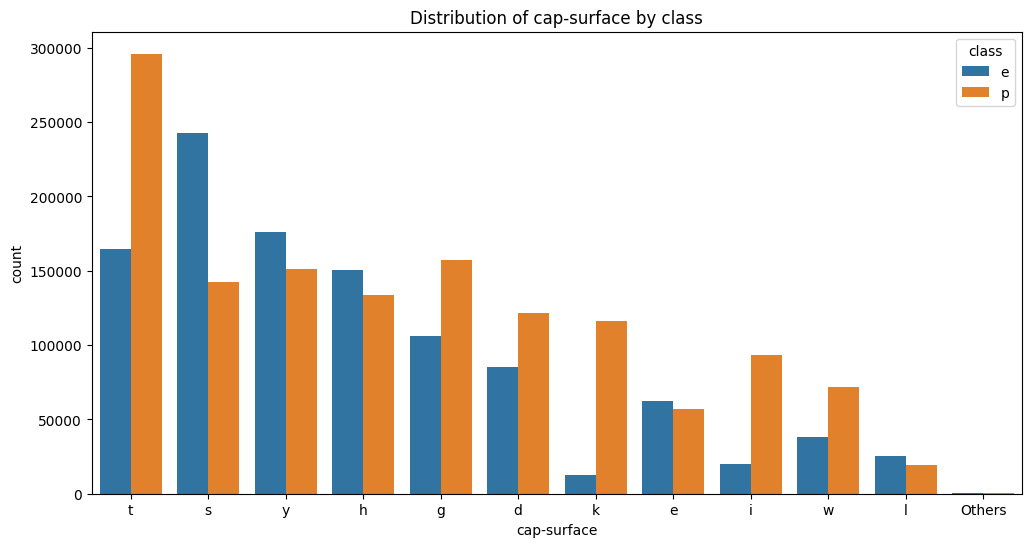

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within cap-surface value (%),p within cap-surface value (%)
cap-surface,,,,,,
t,460777,18.838581,15.182306,21.755086,35.760465,64.239535
s,384970,15.739259,22.369890,10.450196,63.065693,36.934307
y,327826,13.402962,16.251119,11.131070,53.801712,46.198288
h,284460,11.629970,13.887845,9.828929,52.987063,47.012937
g,263729,10.782396,9.788301,11.575357,40.281501,59.718499
d,206832,8.456198,7.853842,8.936680,41.211708,58.788292
k,128875,5.268974,1.168968,8.539430,9.844423,90.155577
e,119712,4.894351,5.752979,4.209448,52.156843,47.843157
i,113440,4.637924,1.861393,6.852682,17.808533,82.191467


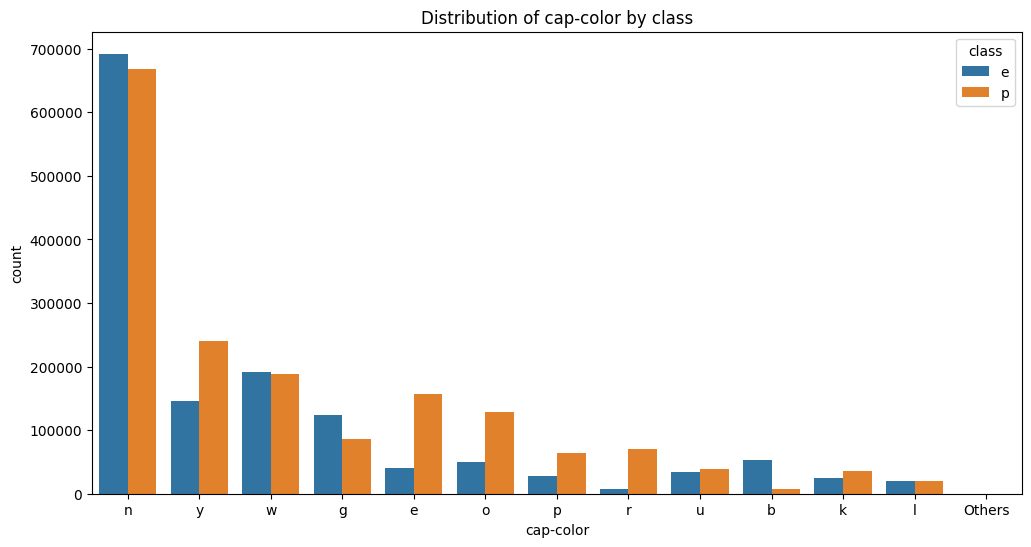

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within cap-color value (%),p within cap-color value (%)
cap-color,,,,,,
n,1359542,43.617941,49.033113,39.135847,50.908468,49.091532
y,386627,12.404084,10.327585,14.122786,37.705075,62.294925
w,379442,12.173569,13.519773,11.059328,50.294116,49.705884
g,210825,6.763861,8.783456,5.092257,58.808016,41.191984
e,197290,6.329620,2.889752,9.176770,20.675148,79.324852
o,178847,5.737916,3.582399,7.522020,28.273888,71.726112
p,91838,2.946422,2.017371,3.715390,31.006773,68.993227
r,78236,2.510031,0.515820,4.160625,9.306457,90.693543
u,73172,2.347564,2.388101,2.314012,46.068168,53.931832


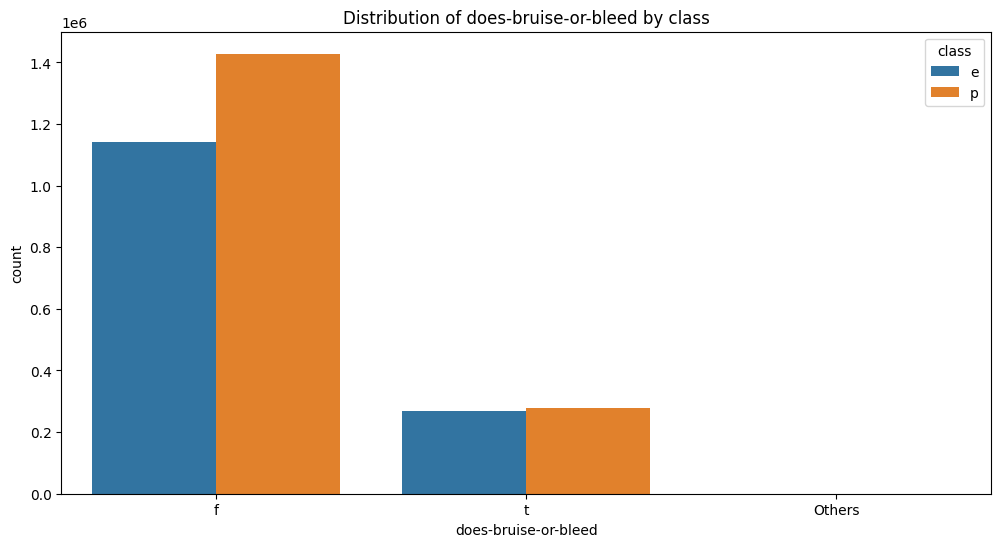

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within does-bruise-or-bleed value (%),p within does-bruise-or-bleed value (%)
does-bruise-or-bleed,,,,,,
f,2569743,82.444496,80.874135,83.744275,44.423664,55.576336
t,547085,17.552007,19.122252,16.252324,49.337671,50.662329
Others,109,0.003497,0.003613,0.003401,46.788991,53.211009


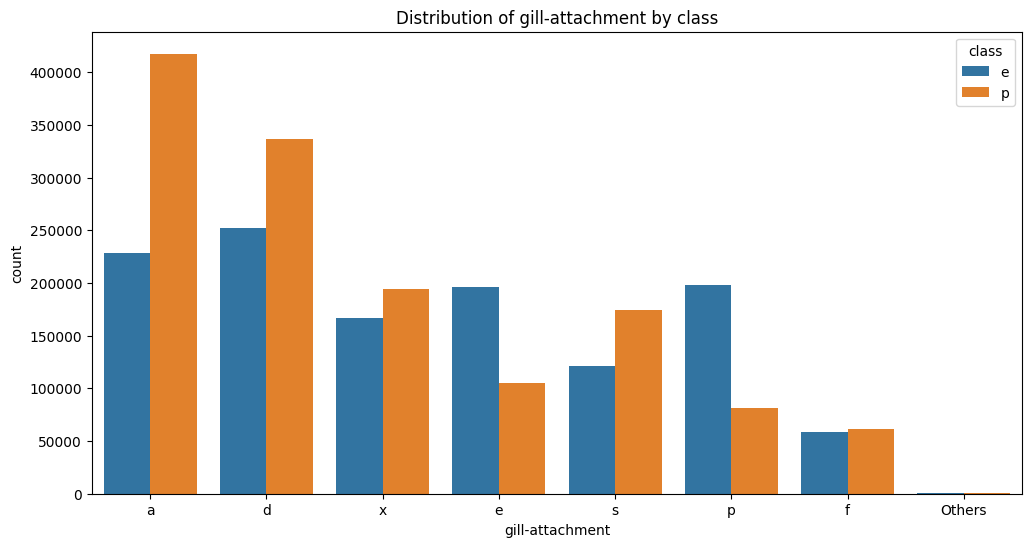

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within gill-attachment value (%),p within gill-attachment value (%)
gill-attachment,,,,,,
a,646034,24.914453,18.690716,30.465134,35.365631,64.634369
d,589236,22.724024,20.661113,24.563846,42.862283,57.137717
x,360878,13.917345,13.625978,14.177202,46.154933,53.845067
e,301858,11.641225,16.076663,7.685449,65.103459,34.896541
s,295439,11.393674,9.929622,12.699399,41.084285,58.915715
p,279110,10.763943,16.194710,5.920477,70.926516,29.073484
f,119953,4.626016,4.803856,4.467407,48.954174,51.045826
Others,501,0.019321,0.017343,0.021085,42.315369,57.684631


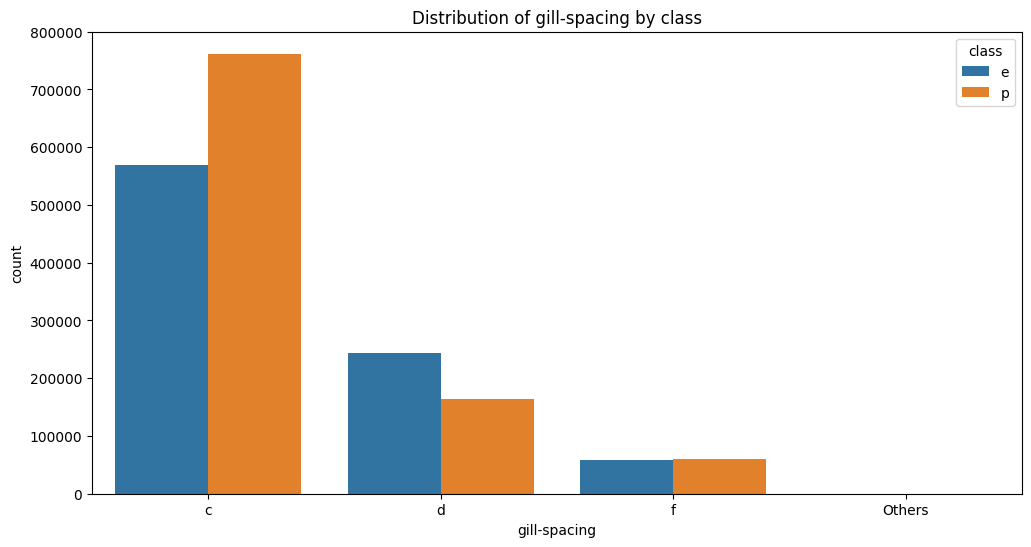

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within gill-spacing value (%),p within gill-spacing value (%)
gill-spacing,,,,,,
c,1331054,71.619416,65.302474,77.196843,42.755440,57.244560
d,407932,21.949411,27.980332,16.624520,59.775404,40.224596
f,119380,6.423425,6.709965,6.170430,48.983079,51.016921
Others,144,0.007748,0.007229,0.008206,43.750000,56.250000


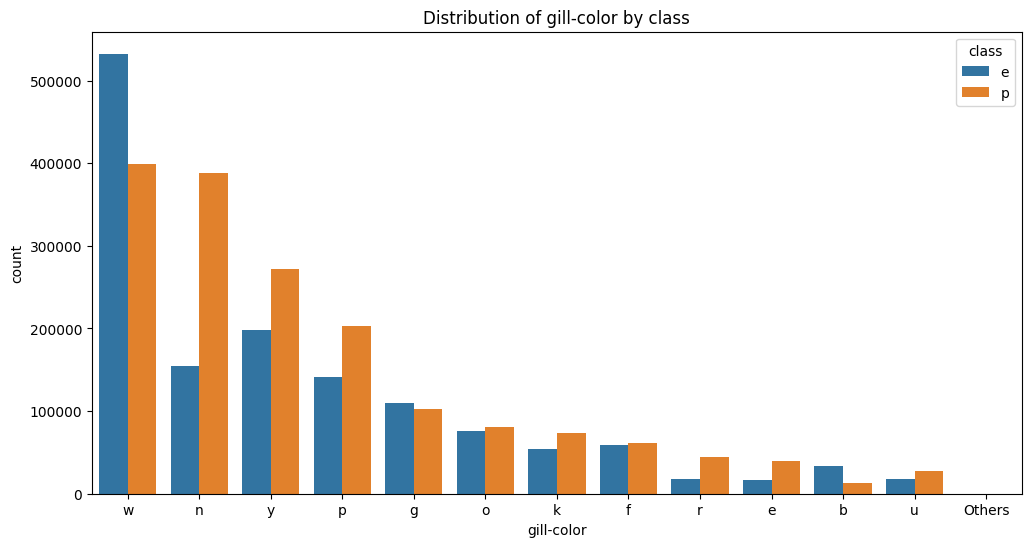

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within gill-color value (%),p within gill-color value (%)
gill-color,,,,,,
w,931538,29.886797,37.720276,23.403070,57.156015,42.843985
n,543386,17.433607,10.976166,22.778395,28.512144,71.487856
y,469464,15.061946,14.000774,15.940273,42.095667,57.904333
p,343626,11.024650,9.976111,11.892520,40.979146,59.020854
g,212164,6.806918,7.801083,5.984053,51.900417,48.099583
o,157119,5.040893,5.372144,4.766719,48.262145,51.737855
k,127970,4.105698,3.831538,4.332618,42.262249,57.737751
f,119694,3.840176,4.156152,3.578645,49.012482,50.987518
r,62799,2.014798,1.272810,2.628937,28.608736,71.391264


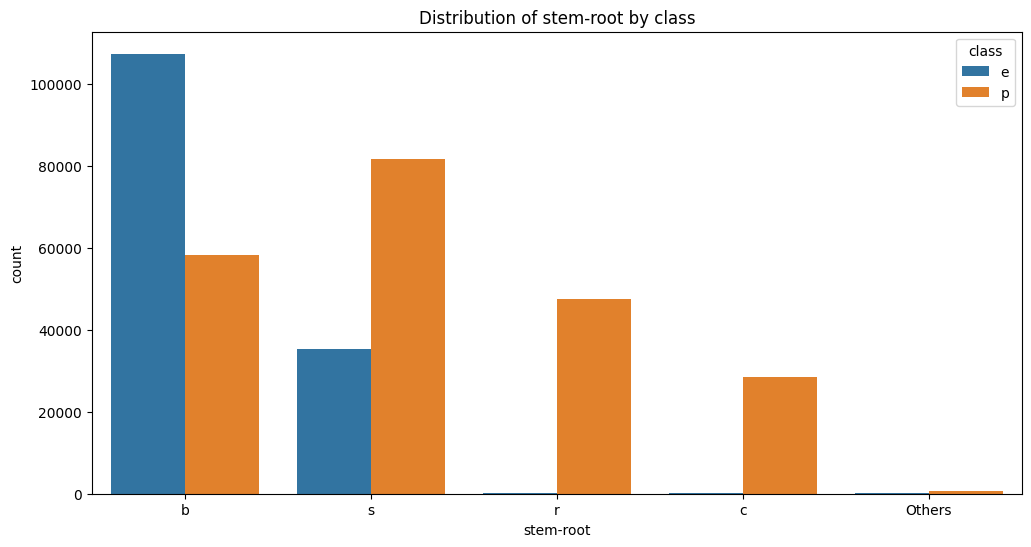

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within stem-root value (%),p within stem-root value (%)
stem-root,,,,,,
b,165801,46.065814,75.085944,26.909311,64.812637,35.187363
s,116946,32.492040,24.624081,37.685765,30.134421,69.865579
r,47803,13.281489,0.159311,21.943581,0.476958,99.523042
c,28592,7.943943,0.081053,13.134323,0.405708,99.594292
Others,780,0.216714,0.049610,0.327020,9.102564,90.897436


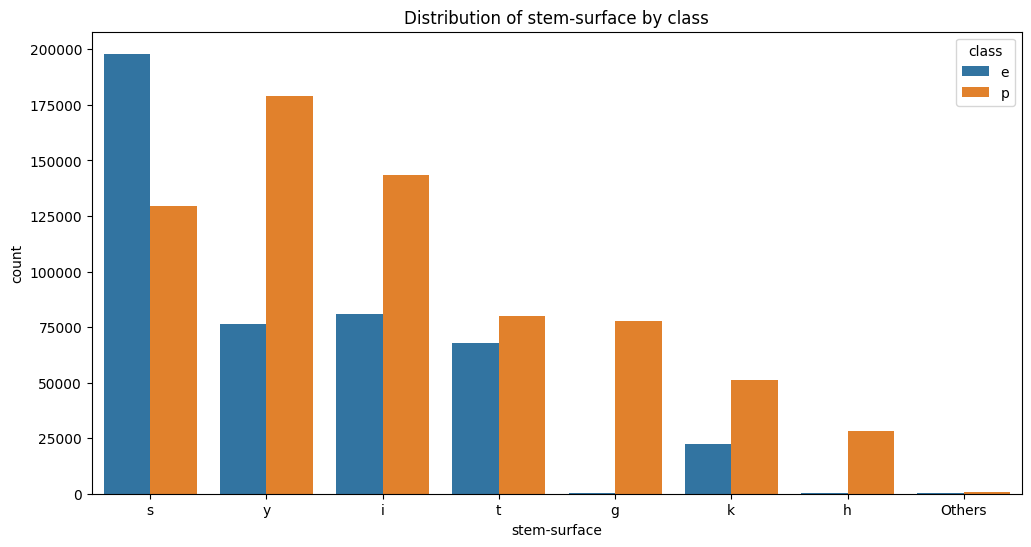

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within stem-surface value (%),p within stem-surface value (%)
stem-surface,,,,,,
s,327610,28.836776,44.383833,18.781545,60.449315,39.550685
y,255500,22.489534,17.135147,25.952543,29.924070,70.075930
i,224346,19.747307,18.173709,20.765050,36.145062,63.854938
t,147974,13.024917,15.213562,11.609387,45.874275,54.125725
g,78080,6.872731,0.068132,11.273681,0.389344,99.610656
k,73383,6.459294,4.967570,7.424082,30.204543,69.795457
h,28283,2.489517,0.023084,4.084709,0.364176,99.635824
Others,908,0.079924,0.034962,0.109003,17.180617,82.819383


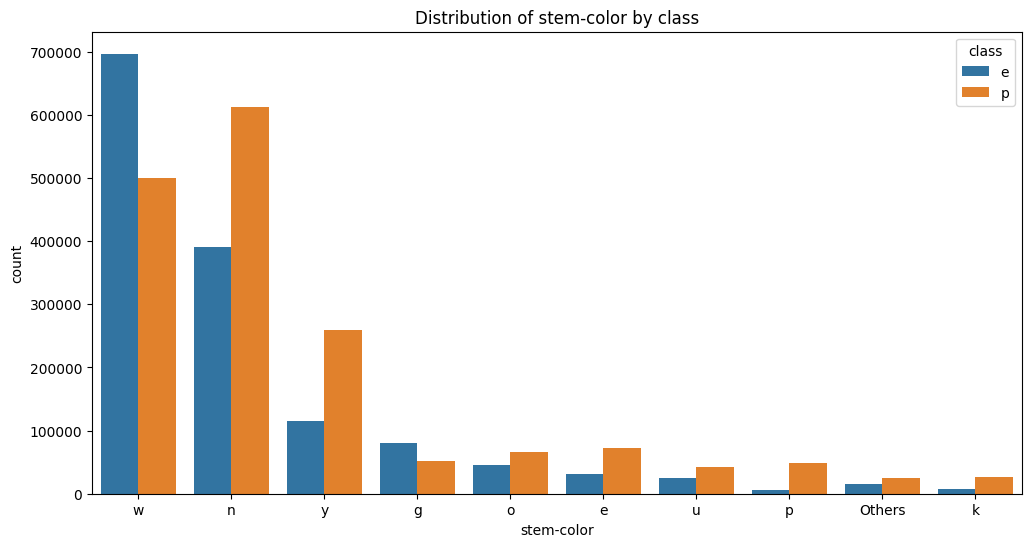

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within stem-color value (%),p within stem-color value (%)
stem-color,,,,,,
w,1196637,38.391810,49.363881,29.310318,58.228602,41.771398
n,1003464,32.194223,27.659388,35.947669,38.907225,61.092775
y,373971,11.998144,8.113123,15.213744,30.622428,69.377572
g,132019,4.235577,5.691988,3.030118,60.857907,39.142093
o,111541,3.578580,3.187255,3.902476,40.334048,59.665952
e,103373,3.316525,2.187558,4.250961,29.870469,70.129531
u,67017,2.150112,1.778286,2.457870,37.454676,62.545324
p,54690,1.754624,0.440303,2.842477,11.364052,88.635948
Others,40519,1.299975,1.069550,1.490695,37.259064,62.740936


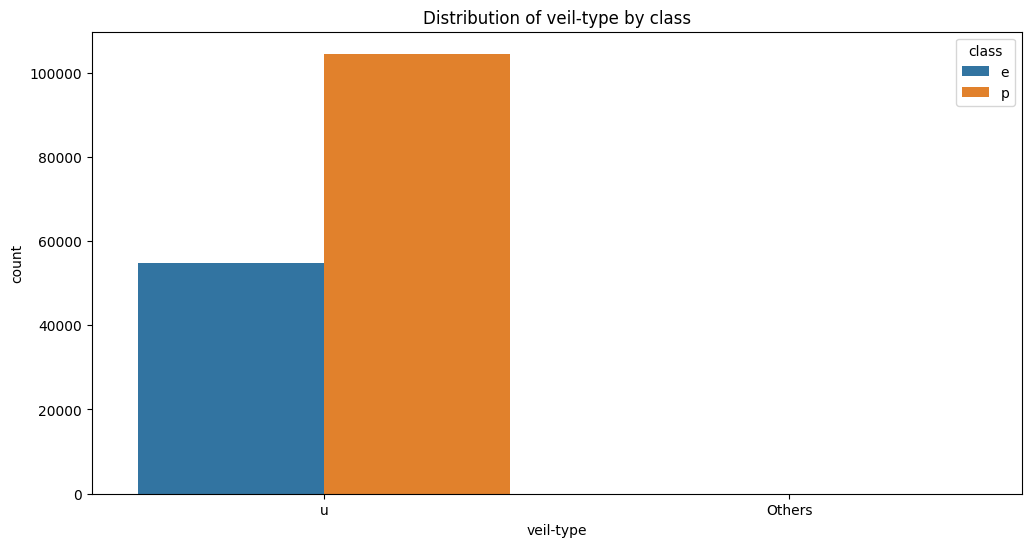

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within veil-type value (%),p within veil-type value (%)
veil-type,,,,,,
u,159373,99.950455,99.938097,99.956949,34.441844,65.558156
Others,79,0.049545,0.061903,0.043051,43.037975,56.962025


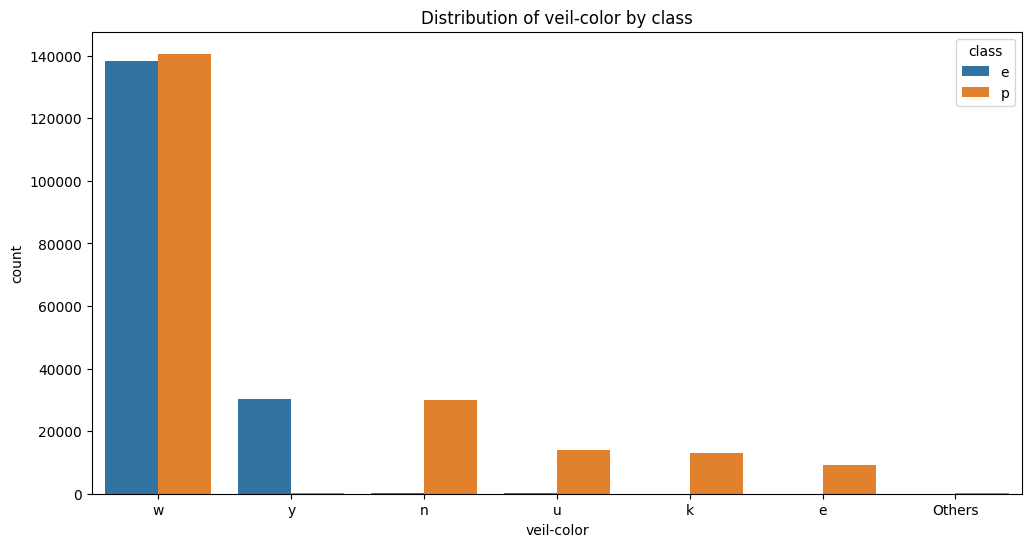

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within veil-color value (%),p within veil-color value (%)
veil-color,,,,,,
w,279070,74.221139,81.907799,67.945429,49.602250,50.397750
y,30473,8.104564,17.937172,0.076813,99.478227,0.521773
n,30039,7.989138,0.066272,14.457697,0.372849,99.627151
u,14026,3.730339,0.049112,6.735846,0.591758,99.408242
k,13080,3.478742,0.006509,6.313618,0.084098,99.915902
e,9169,2.438577,0.005325,4.425185,0.098157,99.901843
Others,141,0.037500,0.027810,0.045411,33.333333,66.666667


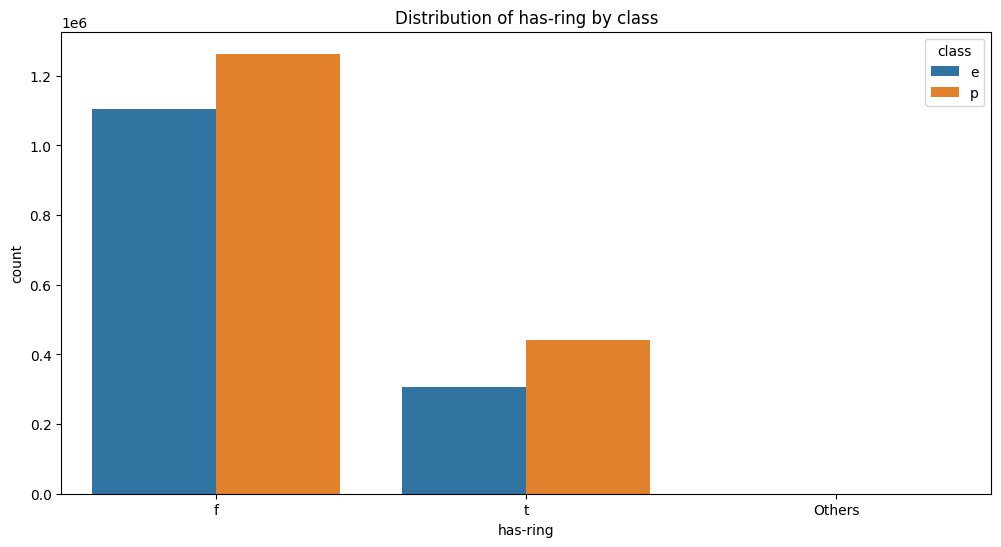

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within has-ring value (%),p within has-ring value (%)
has-ring,,,,,,
f,2368820,75.998718,78.328588,74.070297,46.674589,53.325411
t,747982,23.997464,21.667657,25.925833,40.889620,59.110380
Others,119,0.003818,0.003755,0.003870,44.537815,55.462185


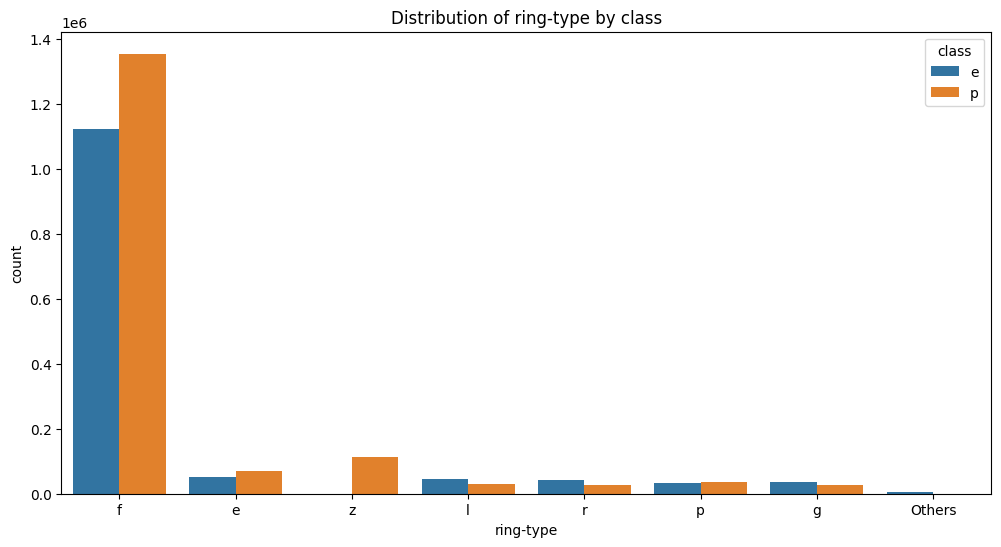

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within ring-type value (%),p within ring-type value (%)
ring-type,,,,,,
f,2477170,82.902146,84.193359,81.861343,45.326158,54.673842
e,120006,4.016178,3.784782,4.202698,42.059564,57.940436
z,113780,3.807815,0.032768,6.850751,0.384075,99.615925
l,73443,2.457878,3.370566,1.722192,61.203927,38.796073
r,67909,2.272675,3.081649,1.620588,60.517752,39.482248
p,67678,2.264944,2.465649,2.103162,48.585951,51.414049
g,63687,2.131379,2.762814,1.622401,57.853251,42.146749
Others,4392,0.146985,0.308412,0.016863,93.647541,6.352459


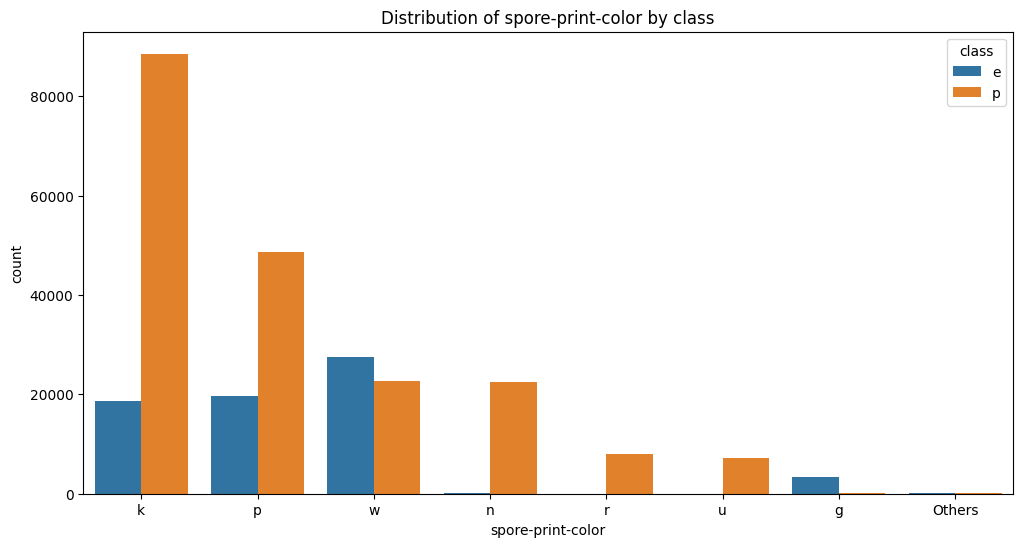

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within spore-print-color value (%),p within spore-print-color value (%)
spore-print-color,,,,,,
k,107310,40.151461,26.962089,44.787063,17.463424,82.536576
p,68237,25.531780,28.244011,24.578525,28.768850,71.231150
w,50173,18.772894,39.661895,11.431143,54.943894,45.056106
n,22646,8.473302,0.089202,11.420018,0.273779,99.726221
r,7975,2.983952,0.031652,4.021582,0.275862,99.724138
u,7256,2.714929,0.031652,3.658006,0.303197,99.696803
g,3492,1.306578,4.881663,0.050061,97.164948,2.835052
Others,174,0.065104,0.097835,0.053601,39.080460,60.919540


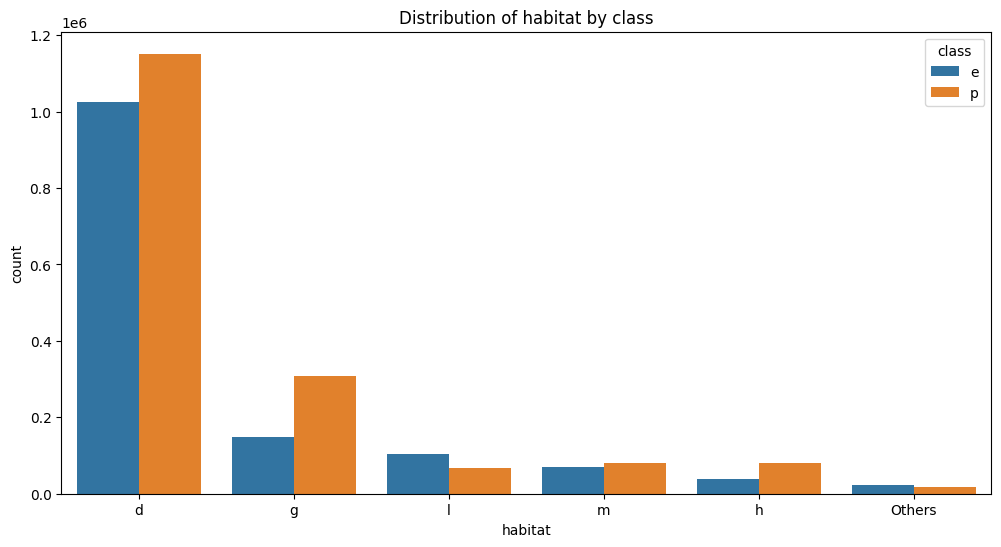

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within habitat value (%),p within habitat value (%)
habitat,,,,,,
d,2177573,69.863422,72.686389,67.526869,47.116124,52.883876
g,454908,14.594886,10.486941,17.995008,32.539766,67.460234
l,171892,5.514838,7.368474,3.980595,60.507761,39.492239
m,150969,4.843563,4.945424,4.759252,46.238632,53.761368
h,120137,3.854375,2.815957,4.713866,33.085561,66.914439
Others,41421,1.328917,1.696815,1.024409,57.823326,42.176674


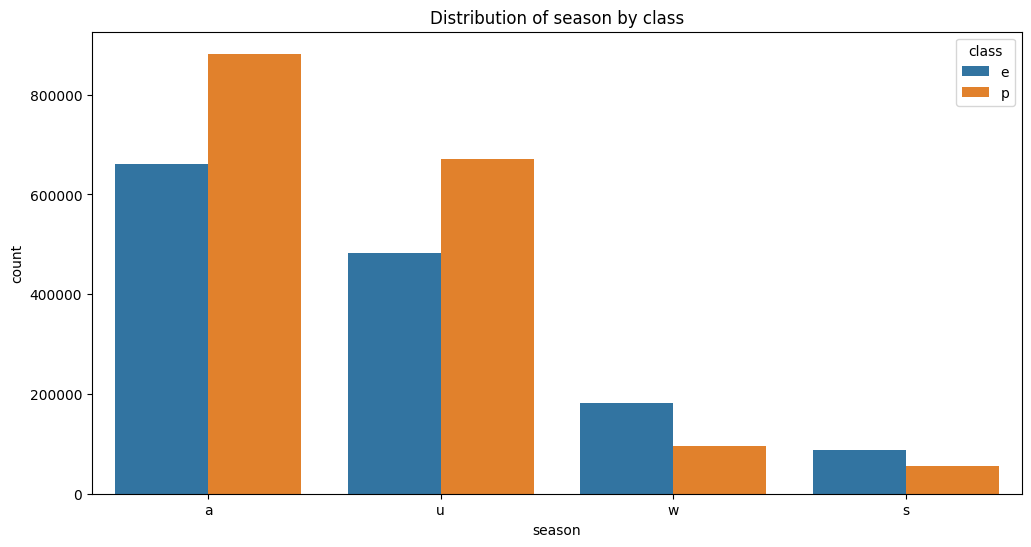

,Total Count,Total Percentage,e of Total (%),p of Total (%),e within season value (%),p within season value (%)
season,,,,,,
a,1543321,49.513899,46.840740,51.726461,42.841379,57.158621
u,1153588,37.010214,34.123364,39.399647,41.753902,58.246098
w,278189,8.925053,12.888890,5.644202,65.399063,34.600937
s,141847,4.550834,6.147006,3.229690,61.170134,38.829866


In [17]:
for col in cat_cols:
    display(categorical_feature(df, col, target='class'))

## Numerical Features

In [18]:
def analyze_numerical_distribution(df, feature_col, target_col=None, figsize=(15, 6), bins=30):
    """
    Analyze the distribution of a numerical feature and detect outliers.
    Parameters:
    - df: pandas DataFrame, the dataset containing the numerical feature.
    - feature_col: str, the name of the numerical feature column to analyze.
    - target_col: str, the target column to compare against (for the box plot). Optional.
    - figsize: tuple, the size of the figure for the plots.
    - bins: int, the number of bins for the histogram.
    Returns:
    - summary_df: pandas DataFrame, a summary of statistics for the overall feature data and outliers.
    """
    # Check if feature_col exists in the dataframe
    if feature_col not in df.columns:
        raise ValueError(f"Column '{feature_col}' not found in the dataframe.")
    
    # Check if target_col exists in the dataframe (if provided)
    if target_col and target_col not in df.columns:
        raise ValueError(f"Column '{target_col}' not found in the dataframe.")
    
    # Create the figure and subplots
    fig, ax = plt.subplots(2, 1, figsize=figsize, sharex=True)

    # First plot: Histogram with KDE
    sns.histplot(df, x=feature_col, kde=True, ax=ax[0], bins=bins)
    ax[0].set_title(f'Distribution of {feature_col} with KDE')
    ax[0].set_ylabel('Frequency')
    ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Second plot: Boxplot of the feature by the target (if provided)
    if target_col:
        # Check seaborn version to decide whether to include the 'gap' parameter
        if sns.__version__ >= '0.13':
            sns.boxplot(df, x=feature_col, ax=ax[1], hue=target_col, gap=0.05)
        else:
            sns.boxplot(df, x=feature_col, ax=ax[1], hue=target_col)
        ax[1].set_title(f'Box Plot of {feature_col} by {target_col} Status')
    else:
        sns.boxplot(df, x=feature_col, ax=ax[1])
        ax[1].set_title(f'Box Plot of {feature_col}')

    ax[1].set_ylabel('')
    ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plots
    plt.show()

    # Calculate overall statistics
    overall_summary = df[feature_col].describe().to_frame().T
    overall_summary.index = [f'{feature_col}_Overall']

    # Calculate the lower and upper bounds for outliers
    Q1 = df[feature_col].quantile(0.25)
    Q3 = df[feature_col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify lower and upper bound outliers
    lower_outliers = df[df[feature_col] < lower_bound]
    upper_outliers = df[df[feature_col] > upper_bound]

    # Get descriptive statistics for lower and upper outliers
    lower_outliers_summary = lower_outliers[feature_col].describe().to_frame().T
    lower_outliers_summary.index = [f'{feature_col}_Lower_Outliers']

    upper_outliers_summary = upper_outliers[feature_col].describe().to_frame().T
    upper_outliers_summary.index = [f'{feature_col}_Upper_Outliers']

    # Combine overall statistics with lower and upper outlier statistics
    summary_df = pd.concat([overall_summary, lower_outliers_summary, upper_outliers_summary])

    # Print the percentage of outliers in the data
    outlier_percentage = ((len(lower_outliers) + len(upper_outliers)) / len(df)) * 100
    lower_outliers_percentage = (len(lower_outliers) / len(df)) * 100
    upper_outliers_percentage = (len(upper_outliers) / len(df)) * 100
    outliers_df = pd.DataFrame({
        'Outlier Percentage': [outlier_percentage],
        'Lower Outliers Percentage': [lower_outliers_percentage],
        'Upper Outliers Percentage': [upper_outliers_percentage]
    })

    print(f"Statistics of the {feature_col} column:\n")
    # print(f"Number of outliers:\n")
    # print(outliers_df)
    return outliers_df, summary_df


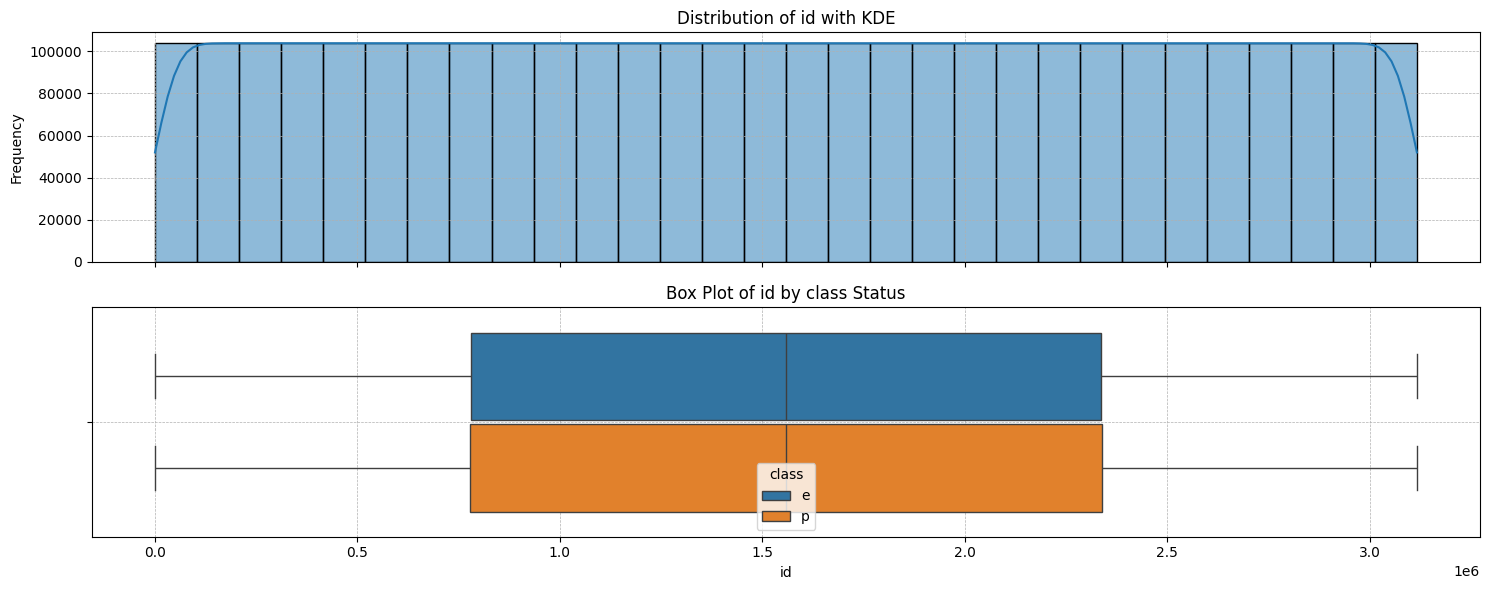

Statistics of the id column:



,Outlier Percentage,Lower Outliers Percentage,Upper Outliers Percentage
0,0.0,0.0,0.0


,count,mean,std,min,25%,50%,75%,max
id_Overall,3116945.0,1558472.0,899784.661737,0.0,779236.0,1558472.0,2337708.0,3116944.0
id_Lower_Outliers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id_Upper_Outliers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


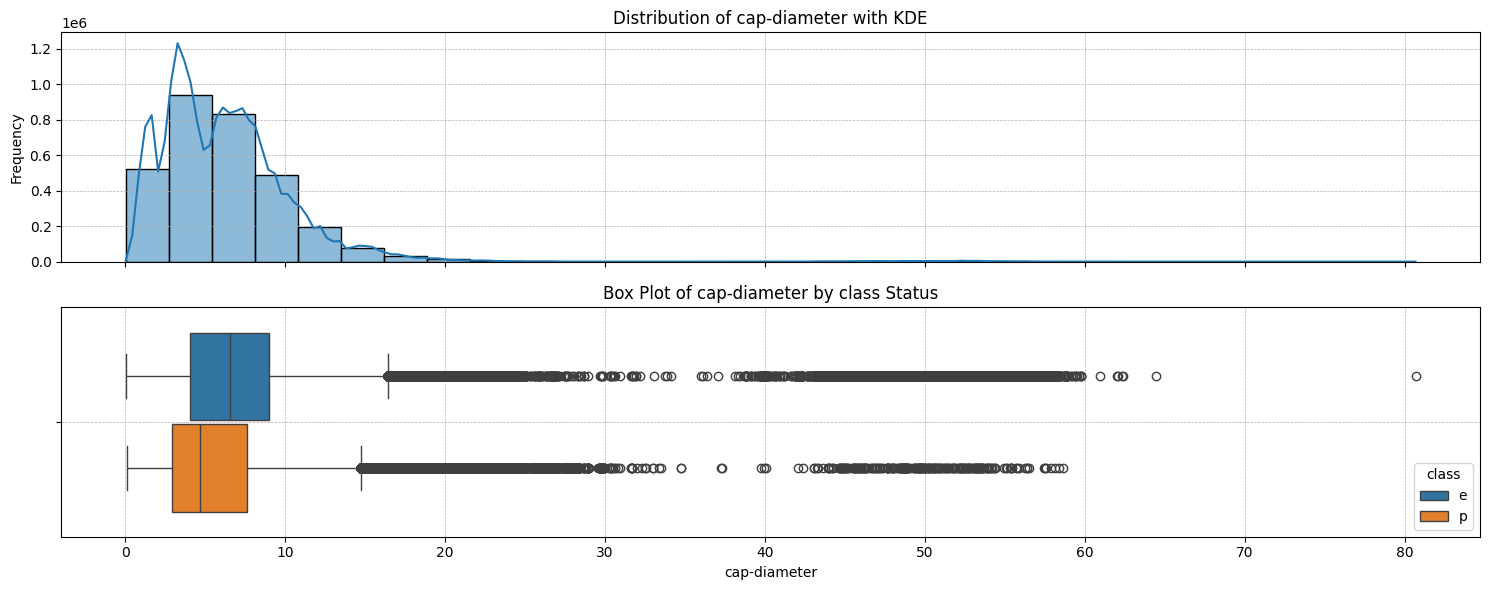

Statistics of the cap-diameter column:



,Outlier Percentage,Lower Outliers Percentage,Upper Outliers Percentage
0,2.442263,0.0,2.442263


,count,mean,std,min,25%,50%,75%,max
cap-diameter_Overall,3116941.0,6.309848,4.657931,0.03,3.32,5.75,8.24,80.67
cap-diameter_Lower_Outliers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cap-diameter_Upper_Outliers,76124.0,23.581559,12.333426,15.63,16.54,18.01,21.53,80.67


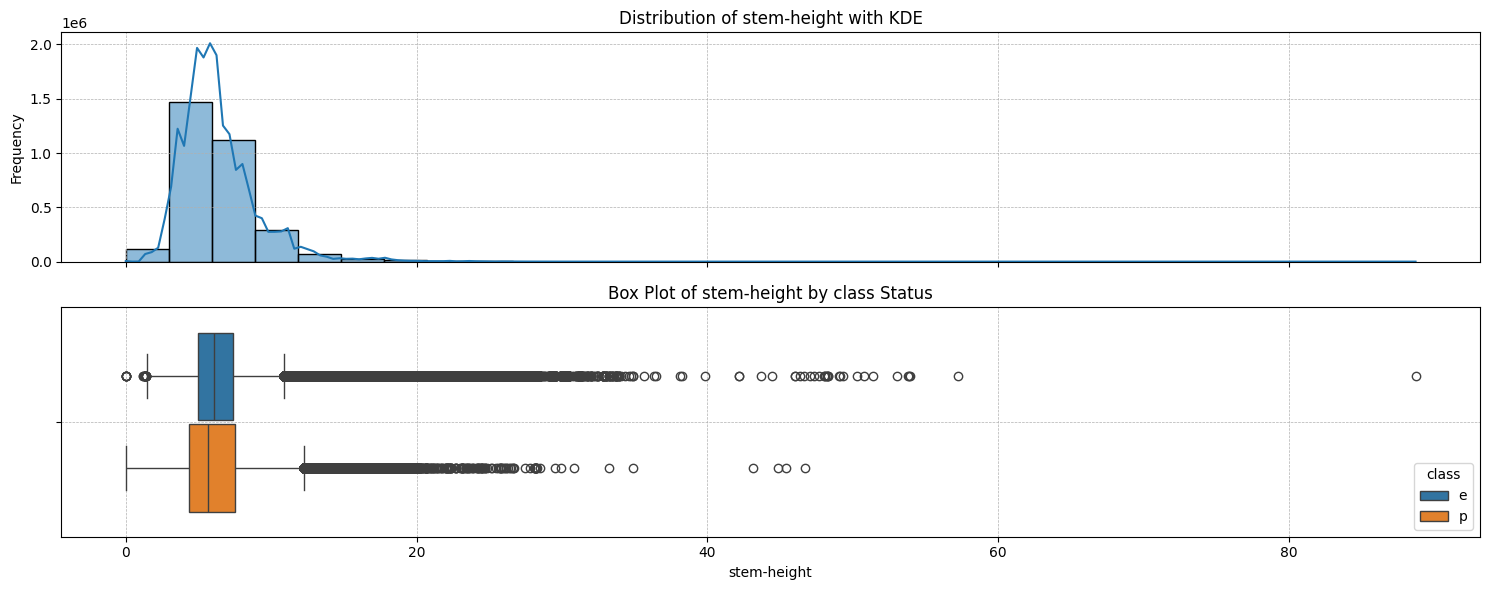

Statistics of the stem-height column:



,Outlier Percentage,Lower Outliers Percentage,Upper Outliers Percentage
0,4.248359,0.017774,4.230585


,count,mean,std,min,25%,50%,75%,max
stem-height_Overall,3116945.0,6.348333,2.699755,0.00,4.67,5.88,7.41,88.72
stem-height_Lower_Outliers,554.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
stem-height_Upper_Outliers,131865.0,14.664202,3.230135,11.53,12.30,13.34,16.49,88.72


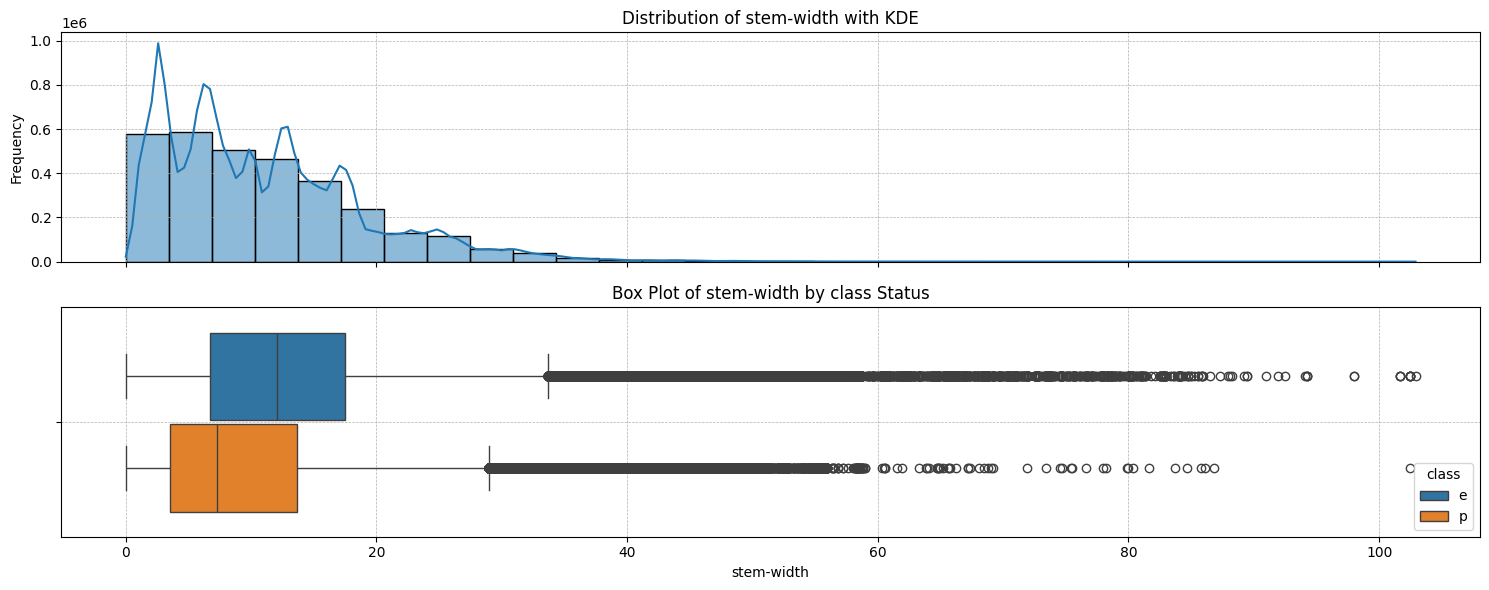

Statistics of the stem-width column:



,Outlier Percentage,Lower Outliers Percentage,Upper Outliers Percentage
0,2.13289,0.0,2.13289


,count,mean,std,min,25%,50%,75%,max
stem-width_Overall,3116945.0,11.153785,8.095477,0.00,4.97,9.65,15.63,102.9
stem-width_Lower_Outliers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stem-width_Upper_Outliers,66481.0,37.512169,6.757450,31.63,33.04,35.08,39.69,102.9


In [19]:
for col in num_cols:
    outliers, summary = analyze_numerical_distribution(df, col, target_col='class')
    display(outliers)
    display(summary)

**Numerical Features Analysis**:



In [23]:
df[num_cols].describe().map('{:.6f}'.format)

,id,cap-diameter,stem-height,stem-width
count,3116945.000000,3116941.000000,3116945.000000,3116945.000000
mean,1558472.000000,6.309848,6.348333,11.153785
std,899784.661737,4.657931,2.699755,8.095477
min,0.000000,0.030000,0.000000,0.000000
25%,779236.000000,3.320000,4.670000,4.970000
50%,1558472.000000,5.750000,5.880000,9.650000
75%,2337708.000000,8.240000,7.410000,15.630000
max,3116944.000000,80.670000,88.720000,102.900000


In [21]:
get_missing_values_summary(df)

,Missing Count,Missing Percentage,Data Type
cap-diameter,4,0.00,float64
cap-shape,40,0.00,object
cap-surface,671023,21.53,object
cap-color,12,0.00,object
does-bruise-or-bleed,8,0.00,object
gill-attachment,523936,16.81,object
gill-spacing,1258435,40.37,object
gill-color,57,0.00,object
stem-root,2757023,88.45,object
stem-surface,1980861,63.55,object
